In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(3,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output


In [2]:
### (2) Model
network = PINN()
network = network.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)#, weight_decay=1e-5)


In [3]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x, y, t, network):
    E = network(x, y, t)  # the dependent variable u is given by the network based on independent variables x, y, t

    # First-order derivatives
    dEdx = torch.autograd.grad(E.sum(), x, create_graph=True)[0]
    dEdy = torch.autograd.grad(E.sum(), y, create_graph=True)[0]
    dEdt = torch.autograd.grad(E.sum(), t, create_graph=True)[0]

    # Second-order derivatives
    d2Edx2 = torch.autograd.grad(dEdx.sum(), x, create_graph=True)[0]
    d2Edy2 = torch.autograd.grad(dEdy.sum(), y, create_graph=True)[0]
    d2Edt2 = torch.autograd.grad(dEdt.sum(), t, create_graph=True)[0]

    # PDE
    pde = d2Edt2 - 1 / (1 * 1) * (d2Edx2 + d2Edy2)
    
    return pde


In [4]:

er1, mur1 = 1, 1
er2, mur2 = 2, 1


a, ratio = 5, 0.25

# Define dimensions for the 3D array
Time, Ny, Nx = 100, 20, 20

# Define ranges for each axis
t = np.arange(Time)
y = np.arange(Ny)
x = np.arange(Nx)

# Create 3D meshgrid
mesh_t, mesh_y, mesh_x = np.meshgrid(t, y, x, indexing='ij')

t = np.ravel(mesh_t).reshape(-1,1)
y = np.ravel(mesh_y).reshape(-1,1)
x = np.ravel(mesh_x).reshape(-1,1)

points_where_x_is_zero = (mesh_x == 0)
points_where_t_is_zero = (mesh_t == 0)

collocation = (mesh_x != 0)

# Initialize 3D array with zeros
E = np.zeros((Time, Ny, Nx))

er  = np.ones((Time, Ny, Nx))*er1
mur = np.ones((Time, Ny, Nx))*mur1


r, phi = [np.zeros((Time, Ny, Nx), dtype=np.float32) for _ in range(2)]

def carToPolar(r, phi, Ny=10, Nx=10, cy=0, cx=0):
    for i in range(Ny):
        for j in range(Nx):
            r[:, i, j] = np.sqrt((i - cy)**2 + (j - cx)**2)
            phi[:, i, j] = np.arctan2((i - cy), (j - cx))


def circle(r, a, Ny=10, Nx=10):
    inside = np.zeros((Time, Ny, Nx), dtype=bool)
    for k in range(Time):
        for i in range(Ny):
            for j in range(Nx):
                if (r[k, i, j]) <= a:
                    inside[k, i, j] = True
    return inside

cx, cy = Nx//2 + 0.5, Ny//2 + 0.5



carToPolar(r, phi, Ny, Nx, cy, cx)

scatterer = circle(r, a, Ny, Nx)



er[scatterer]  = er2
mur[scatterer] = mur2



er  = np.ravel(er).reshape(-1,1)
mur = np.ravel(mur).reshape(-1,1)



er  = torch.tensor(er, dtype=torch.float32, device=device, requires_grad=False)
mur = torch.tensor(mur, dtype=torch.float32, device=device, requires_grad=False)


E0 = 1

velocity = 1 / np.sqrt(er1 * mur1)

wavelength = a / ratio
period = wavelength / velocity
omega = 2 * np.pi / period


In [5]:
###### Data from Boundary Conditions
# compute E based on BC

x_bc = mesh_x[points_where_x_is_zero]
x_bc = np.ravel(x_bc).reshape(-1,1)

y_bc = mesh_y[points_where_x_is_zero]
y_bc = np.ravel(y_bc).reshape(-1,1)

t_bc = mesh_t[points_where_x_is_zero]
t_bc = np.ravel(t_bc).reshape(-1,1)

E_bc = E0*np.sin(omega * t_bc) #np.zeros((len(t_bc), 1))#



x_ic = mesh_x[points_where_t_is_zero]
x_ic = np.ravel(x_ic).reshape(-1,1)

y_ic = mesh_y[points_where_t_is_zero]
y_ic = np.ravel(y_ic).reshape(-1,1)

t_ic = mesh_t[points_where_t_is_zero]
t_ic = np.ravel(t_ic).reshape(-1,1)

E_ic = np.ones((len(t_ic), 1))

In [6]:
### (3) Training / Fitting
iterations = 10000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = torch.tensor(x_bc, dtype=torch.float32, device=device, requires_grad=False)
    pt_y_bc = torch.tensor(y_bc, dtype=torch.float32, device=device, requires_grad=False)
    pt_t_bc = torch.tensor(t_bc, dtype=torch.float32, device=device, requires_grad=False)
    pt_E_bc = torch.tensor(E_bc, dtype=torch.float32, device=device, requires_grad=False)

    
    net_bc_out = network(pt_x_bc, pt_y_bc, pt_t_bc) # output of E(x, y, t)
    mseBoundary = mse_cost_function(net_bc_out, pt_E_bc)

    # print(mseBoundary)

    # Loss based on initial conditions
    pt_x_ic = torch.tensor(x_ic, dtype=torch.float32, device=device, requires_grad=False)
    pt_y_ic = torch.tensor(y_ic, dtype=torch.float32, device=device, requires_grad=False)
    pt_t_ic = torch.tensor(t_ic, dtype=torch.float32, device=device, requires_grad=False)
    pt_E_ic = torch.tensor(E_ic, dtype=torch.float32, device=device, requires_grad=False)

    
    net_ic_out = network(pt_x_ic, pt_y_ic, pt_t_ic) # output of E(x, y, t)
    mseInitial = mse_cost_function(net_ic_out, pt_E_ic)

    # print(mseInitial)
    
    # Loss based on PDE
    x_collocation = mesh_x[collocation]
    x_collocation = np.ravel(x_collocation).reshape(-1,1)
    
    y_collocation = mesh_y[collocation]
    y_collocation = np.ravel(y_collocation).reshape(-1,1)
    
    t_collocation = mesh_t[collocation]
    t_collocation = np.ravel(t_collocation).reshape(-1,1)
    
    all_zeros = np.zeros((len(x_collocation),1))
    
    pt_x_collocation = torch.tensor(x_collocation, dtype=torch.float32, device=device, requires_grad=True)
    pt_y_collocation = torch.tensor(y_collocation, dtype=torch.float32, device=device, requires_grad=True)
    pt_t_collocation = torch.tensor(t_collocation, dtype=torch.float32, device=device, requires_grad=True)
    pt_all_zeros = torch.tensor(all_zeros, dtype=torch.float32, device=device, requires_grad=True)

    
    f_out = f(pt_x_collocation, pt_y_collocation, pt_t_collocation, network) # output of f(x,t)
    # print(np.shape(x))
    msePDE = mse_cost_function(f_out, pt_all_zeros)

    # print(msePDE)
    
    # Combining the loss functions
    loss = mseBoundary + msePDE + mseInitial
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
        if (epoch%100 == 0):
        	print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(1.9529)
100 Traning Loss: tensor(0.9955)
200 Traning Loss: tensor(0.4663)
300 Traning Loss: tensor(0.4625)
400 Traning Loss: tensor(0.4614)
500 Traning Loss: tensor(0.4594)
600 Traning Loss: tensor(0.4385)
700 Traning Loss: tensor(0.4254)
800 Traning Loss: tensor(0.4224)
900 Traning Loss: tensor(0.4201)
1000 Traning Loss: tensor(0.4179)
1100 Traning Loss: tensor(0.4169)
1200 Traning Loss: tensor(0.4164)
1300 Traning Loss: tensor(0.4162)
1400 Traning Loss: tensor(0.4158)
1500 Traning Loss: tensor(0.4155)
1600 Traning Loss: tensor(0.4155)
1700 Traning Loss: tensor(0.4155)
1800 Traning Loss: tensor(0.4151)
1900 Traning Loss: tensor(0.4150)
2000 Traning Loss: tensor(0.4150)
2100 Traning Loss: tensor(0.4154)
2200 Traning Loss: tensor(0.4152)
2300 Traning Loss: tensor(0.4149)
2400 Traning Loss: tensor(0.4147)
2500 Traning Loss: tensor(0.4150)
2600 Traning Loss: tensor(0.4150)
2700 Traning Loss: tensor(0.4150)
2800 Traning Loss: tensor(0.4147)
2900 Traning Loss: tensor(

In [7]:
# # Assuming x_collocation, y_collocation, t_collocation are defined and initialized somewhere in your code

# # Define batch size
# batch_size = 100

# # Training loop
# iterations = 100000
# for epoch in range(iterations):
#     optimizer.zero_grad()
    
#     # Loss based on boundary conditions
#     pt_x_bc = torch.tensor(x_bc, dtype=torch.float32, device=device)
#     pt_y_bc = torch.tensor(y_bc, dtype=torch.float32, device=device)
#     pt_t_bc = torch.tensor(t_bc, dtype=torch.float32, device=device)
#     pt_E_bc = torch.tensor(E_bc, dtype=torch.float32, device=device)

#     net_bc_out = network(pt_x_bc, pt_y_bc, pt_t_bc)
#     mseBoundary = mse_cost_function(net_bc_out, pt_E_bc)

#     # Loss based on PDE (collocation points)

#     # Loss based on PDE
#     x_collocation = np.random.uniform(low=0.0, high=Nx, size=(500,1))
#     y_collocation = np.random.uniform(low=0.0, high=Ny, size=(500,1))
#     t_collocation = np.random.uniform(low=0.0, high=Time, size=(500,1))
#     all_zeros = np.zeros((500,1))
    
#     losses = []
#     for batch_idx in range(0, len(x_collocation), batch_size):
#         batch_x = x_collocation[batch_idx:batch_idx+batch_size]
#         batch_y = y_collocation[batch_idx:batch_idx+batch_size]
#         batch_t = t_collocation[batch_idx:batch_idx+batch_size]

#         pt_x_collocation = torch.tensor(batch_x, dtype=torch.float32, device=device, requires_grad=True)
#         pt_y_collocation = torch.tensor(batch_y, dtype=torch.float32, device=device, requires_grad=True)
#         pt_t_collocation = torch.tensor(batch_t, dtype=torch.float32, device=device, requires_grad=True)
        
#         f_out = f(pt_x_collocation, pt_y_collocation, pt_t_collocation, er, mur, network)
#         msePDE = mse_cost_function(f_out, torch.zeros_like(f_out))

#         losses.append(msePDE.mean())  # Collect losses for each batch
    
#     # Combine losses
#     msePDE = torch.stack(losses).mean()


#     # Regularization term (L2 regularization)
#     l2_regularization = 0.0
#     for param in network.parameters():
#         l2_regularization += torch.norm(param)**2  # Sum of squares of all parameters
    
#     # Multiply by regularization strength (lambda)
#     lambda_reg = 1e-5
#     l2_regularization *= lambda_reg
    
#     # Total loss (with regularization)
#     loss = mseBoundary + msePDE + l2_regularization
    
#     loss.backward()
#     optimizer.step()

    
    
#     # # Total loss
#     # loss = mseBoundary + msePDE
    
#     # loss.backward()
#     # optimizer.step()

#     # Print training progress
#     if epoch % 1000 == 0:
#         print(f"Epoch {epoch}: Training Loss: {loss.item()}")

#     # Optionally, you can add validation checks here to monitor validation loss and early stopping criteria


In [8]:


t = torch.tensor(t, dtype=torch.float32, device=device, requires_grad=True)
y = torch.tensor(y, dtype=torch.float32, device=device, requires_grad=True)
x = torch.tensor(x, dtype=torch.float32, device=device, requires_grad=True)

E = network(x, y, t)
E = E.data.cpu().numpy()
E = E.reshape(mesh_x.shape)

# print(type(er))
# er = er.data.cpu().numpy()
er = er.reshape(mesh_x.shape)

print(np.shape(E))

(100, 20, 20)


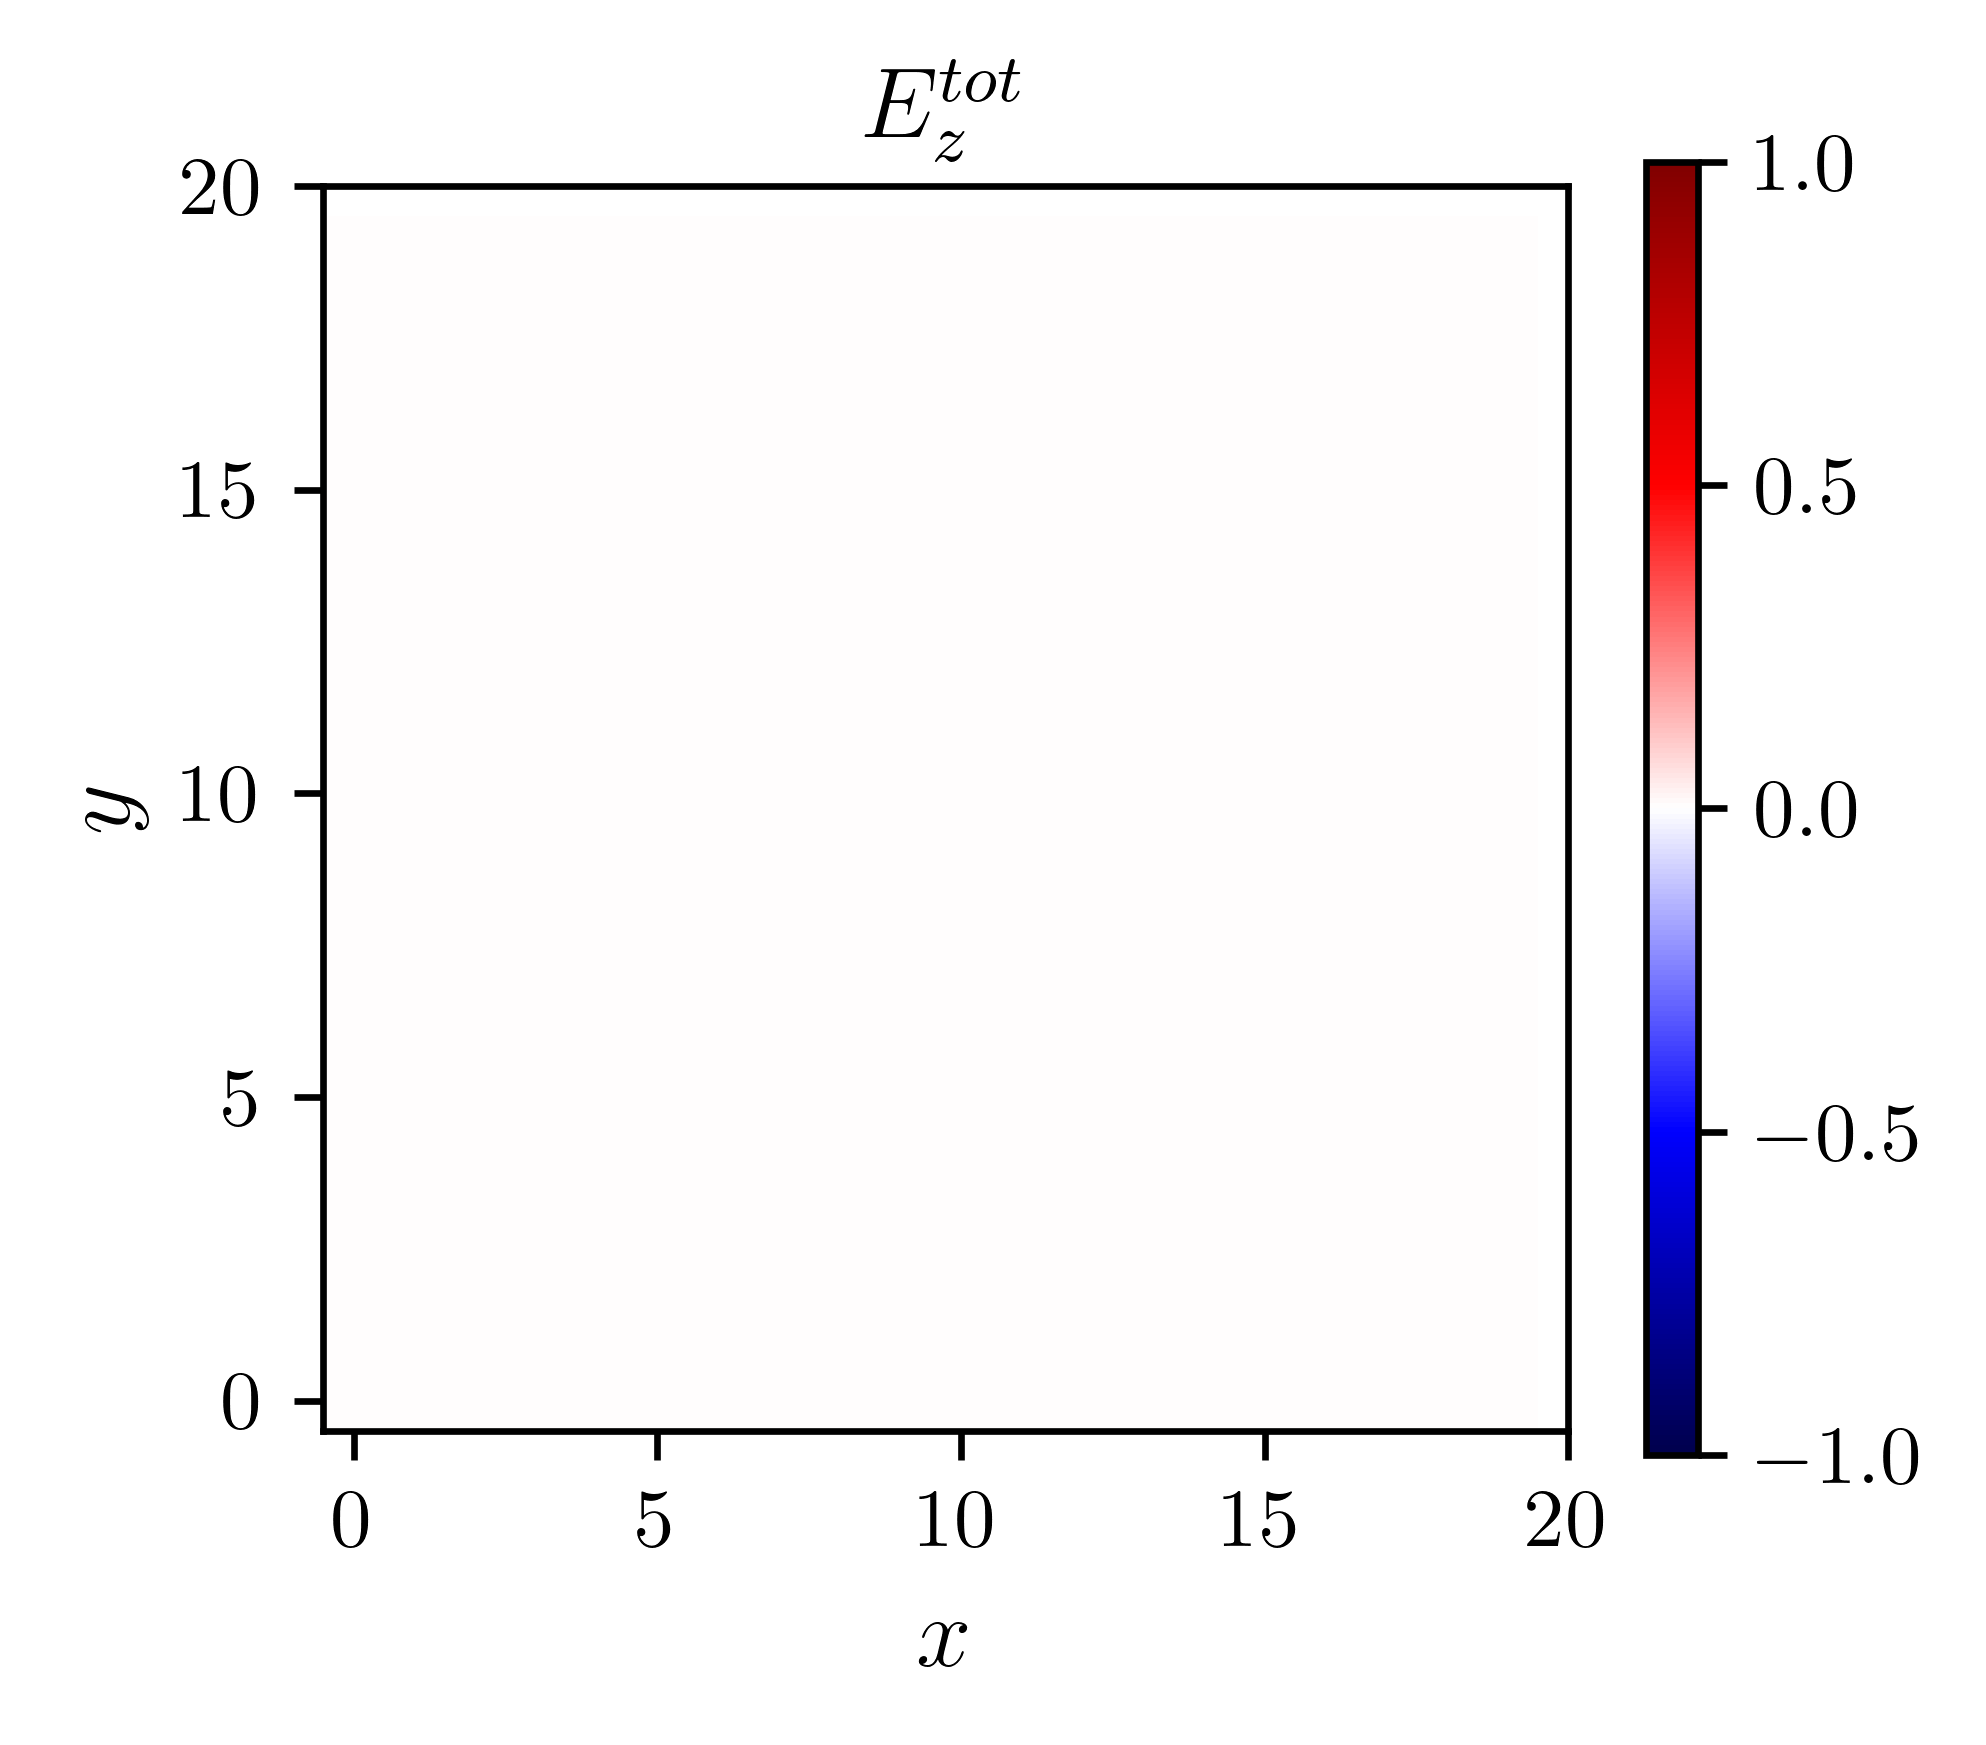

In [9]:
import sys
import os
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Wedge
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import ConnectionPatch



pictures = 'gallery'
if not os.path.exists(pictures):
    os.makedirs(pictures)



fig = plt.figure(figsize = (3.35, 2.95), dpi=600)
gs=GridSpec(1,1)
plt.ion()

fps = 10

Video_Name = "Ez_tot.mp4"

FFMpegWriter = animation.writers['ffmpeg']

metadata = dict(title='Ez_tot', artist='', comment='Movie support!')
writer = FFMpegWriter(fps=fps, metadata=metadata)

with writer.saving(fig, Video_Name,300):
    for i in range(Time):
        
        t1 = time.time()

    ###############################################################################################################
    ##########                                           ANIMATION                                       ##########
    ###############################################################################################################

        if (i%1 == 0):
                
            fig.clear()

            ########### Plot parameters ################
            plt.rc('font', family = 'serif', size = 10)
            plt.rc('xtick', labelsize = 10)
            plt.rc('ytick', labelsize = 10)
            plt.rc('lines', markersize = 2, lw = 0.75)
            plt.rc('text', usetex = True)
            plt.rcParams['image.cmap']='seismic'
            ###########################################
            
            
                        
            ax1 = fig.add_subplot(gs[0,0])
            plt.title(r'$E_z^{tot}$')
            im1 = plt.imshow(E[i], vmin = -1, vmax = 1, cmap='seismic', origin='lower')
            # im = plt.imshow(er[i], extent=(0, Nx, 0, Ny), cmap='binary', origin='lower', alpha=0.5)
            
            ax1.set_xticks(np.linspace(0,Nx,5))
            #ax1.set_xticklabels([])
            ax1.set_xlabel(r'$x$', fontsize=12)
            ax1.set_yticks(np.linspace(0,Ny,5))
            #ax1.set_yticklabels([])
            ax1.set_ylabel(r'$y$', fontsize=12)

            fig.colorbar(im1, ax = ax1, location='right', shrink=0.95, aspect=25)
            # fig.tight_layout()
            plt.savefig(pictures+"/pic."+str(i).zfill(4)+".svg")
            writer.grab_frame()     

    ###############################################################################################################
    ###############################################################################################################





In [10]:
# import numpy as np

# # Define dimensions for the 3D array
# Time, Ny, Nx = 5, 10, 10

# # Define ranges for each axis
# t = np.arange(Time)
# y = np.arange(Ny)
# x = np.arange(Nx)

# # Create 3D meshgrid
# mesh_t, mesh_y, mesh_x = np.meshgrid(t, y, x, indexing='ij')

# # Select points where x-coordinate is zero
# points_where_x_is_zero = (mesh_x == 0)

# # Display selected points
# print("Selected points where x is zero:")
# print(np.column_stack([mesh_t[points_where_x_is_zero], mesh_y[points_where_x_is_zero], mesh_x[points_where_x_is_zero]]))
